This notebook is used to test small performance differences in **RxInfer.jl** during the development process for a very simple model. This benchmark does not represent the whole range of possible regressions but is quick and easy to execute.

In [1]:
using RxInfer, BenchmarkTools, Random, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662


In [2]:
@model function smoothing(n; c::ConstVariable, v::ConstVariable)
    
    x_prior ~ Normal(mean = 0.0, variance = 10000.0) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ Normal(mean = x[i], variance = v)
        x_prev = x[i]
    end
    
    return x, y
end

In [3]:
seed = 123

rng = MersenneTwister(seed)

v = 100.0

# For large `n` apply: smoothing(model_options(limit_stack_depth = 500), ...)
n = 500

hidden = collect(1:n)
data   = hidden + rand(rng, Normal(0.0, sqrt(v)), n);

In [4]:
(posteriors, _) = inference(
    model = smoothing(n, c = 1.0, v = v), 
    data  = (y = data, ), 
    returnvars = KeepLast(),
)

Inference results:
-----------------------------------------
x_prior = NormalWeightedMeanPrecision{Float64}(xi=2.0354954390946265, w=5.000099999999934)...
x       = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=7.0...


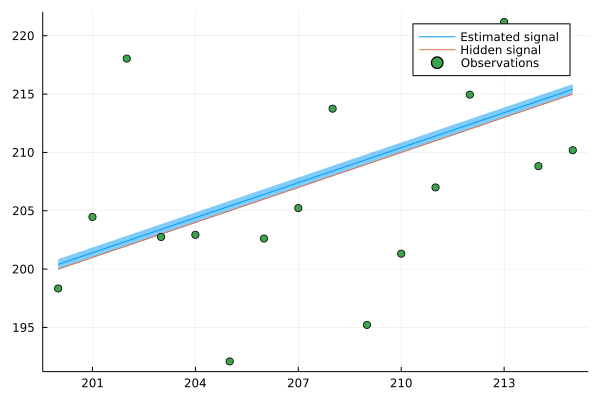

In [5]:
let 
    results = posteriors[:x]
    subrange = 200:215
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

In [6]:
@benchmark res = inference(
    model = smoothing($n, c = 1.0, v = $v), 
    data  = (y = $data, ), 
    returnvars = KeepLast()
)

BenchmarkTools.Trial: 316 samples with 1 evaluation.
 Range (min … max):  11.635 ms … 36.950 ms  ┊ GC (min … max): 0.00% … 52.83%
 Time  (median):     13.628 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.840 ms ±  5.314 ms  ┊ GC (mean ± σ):  8.28% ± 13.80%

   ▃▅▄█▃▂                                                      
  ▄██████▇▄▄▄▃▁▃▁▂▃▃▃▃▄▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▃▃▄▃▃▂▃▁▁▃▂▂▁▂▁▂▃▂▂▂ ▃
  11.6 ms         Histogram: frequency by time        33.9 ms <

 Memory estimate: 8.60 MiB, allocs estimate: 177301.